# Case Study of equipment’s signal quality

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os 
os.chdir('/content/drive/MyDrive/Colab Notebooks')

PROJECT OBJECTIVE: To create a classifier capable of determining a plant's species from a photo

In [5]:
#checking tensorflow version
import tensorflow as tf
tf.__version__

'2.5.0'

1. Import data. 

In [6]:
import numpy as np
import pandas as pd 
import seaborn as sns
import scipy.stats as stats 
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import keras
from keras.layers import Dense,Conv2D,Dropout,BatchNormalization,Activation,Flatten,MaxPool2D,Input,LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Reshape
from keras.optimizers import SGD
from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import h5py

In [7]:
import cv2
import numpy as np
from glob import glob
import seaborn as sns

In [8]:
pip install tflearn 

Load the dataset

In [9]:
import tflearn.datasets.oxflower17 as oxflower17   # Data Library

Instructions for updating:
non-resource variables are not supported in the long term


In [10]:
X, Y = oxflower17.load_data()

2. Preprocess the data.

In [11]:

print('Info: images : ', X.shape)

Info: images :  (1360, 224, 224, 3)


In [12]:
print(' info: Target  : ', Y.shape)

 info: Target  :  (1360,)


In [13]:
from tensorflow.keras.utils import to_categorical

Y_cat = to_categorical(Y)
Y_cat.shape

(1360, 17)

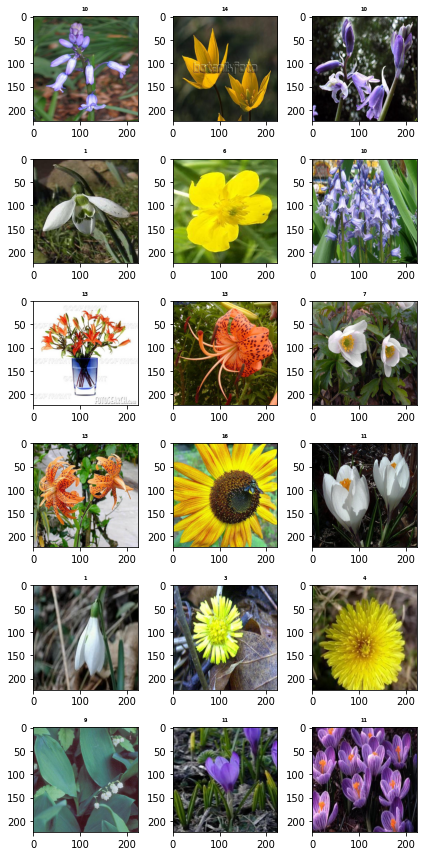

In [14]:
import matplotlib.pyplot as plt

def plot_images(images, labels, num_row=4, num_col=6):
   
    fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col,2*num_row))
    for i in range(0,num_row * num_col):
        ax = axes[i//num_col, i%num_col]       
        ax.imshow(images[i], cmap="gray")
        ax.set_title(labels[i],weight='bold',fontsize=5)
    plt.tight_layout()    
    plt.show()


plot_images(X,Y, num_row=6, num_col=3)

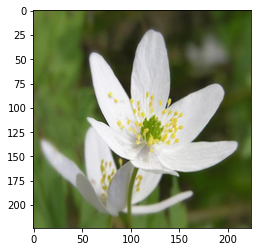

In [15]:
from PIL import Image  
  
plt.imshow(X[25])

In [16]:
def getData(index):
  print (index)
  if index < 0 :
    return False
  
  plt.imshow(X[index])
  return index

2


2

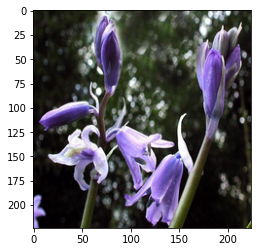

In [17]:
getData(2)

In [18]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

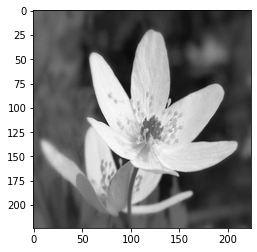

In [19]:
# Grey 
bw_image = np.array(X[25],dtype=np.float32)
bw_image = rgb2gray(bw_image)
bw_image = bw_image/255
plt.imshow(bw_image,cmap='gist_gray')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


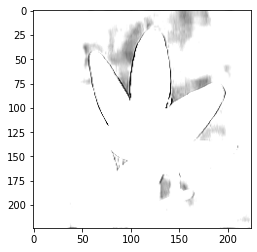

In [20]:
def convolve(image, kernel):
    """
    This function which takes an image and a kernel and returns the convolution of them.

    :param image: a numpy array of size [image_height, image_width].
    :param kernel: a numpy array of size [kernel_height, kernel_width].
    :return: a numpy array of size [image_height, image_width] (convolution output).
    """
    # Flip the kernel
    kernel = np.flipud(np.fliplr(kernel))
    # convolution output
    output = np.zeros_like(image)

    # Add zero padding to the input image
    image_padded = np.zeros((image.shape[0] + 2, image.shape[1] + 2, X[25].shape[2]))
    image_padded[1:-1, 1:-1] = image

    # Loop over every pixel of the image
    for x in range(image.shape[1]):
        for y in range(image.shape[0]):
            # element-wise multiplication of the kernel and the image
            output[y, x]=(kernel * image_padded[y: y+3, x: x+3]).sum()

    return output

# kernel to be used to get sharpened image
KERNEL = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
image_sharpen = convolve(X[25], kernel=KERNEL)
#cv2.imwrite('sharpened_image.jpg', image_sharpen)


plt.imshow(image_sharpen)
plt.show()

4. Train tune and test AIML image classifier model using

In [21]:
# Split the data into train,test 
from sklearn.model_selection import train_test_split
XX_train, X_test, yy_train, y_test = train_test_split(X, Y_cat, test_size=0.2, random_state=0)

# validation
X_train,X_val,y_train,y_val = train_test_split(XX_train, yy_train, test_size=0.2, random_state=0)

In [22]:
# Convert to float 32 format  

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')

In [23]:
# Normalize  
X_train = X_train / 255.
X_test = X_test / 255.
X_val = X_val / 255.

In [24]:
X_train

array([[[[3.5371011e-04, 3.9984621e-04, 3.0757402e-04],
         [4.4598232e-04, 5.6901196e-04, 1.9992310e-04],
         [3.8446751e-04, 6.6128414e-04, 1.5378702e-05],
         ...,
         [7.0742023e-04, 1.6916571e-03, 9.2272203e-05],
         [5.8439065e-04, 1.5840061e-03, 0.0000000e+00],
         [5.9976935e-04, 1.6147635e-03, 1.5378702e-05]],

        [[2.9219533e-04, 3.5371011e-04, 2.3068051e-04],
         [3.2295272e-04, 4.7673972e-04, 1.2302962e-04],
         [3.3833142e-04, 6.1514805e-04, 0.0000000e+00],
         ...,
         [6.4590544e-04, 1.6455210e-03, 4.6136101e-05],
         [5.6901196e-04, 1.5840061e-03, 0.0000000e+00],
         [6.1514805e-04, 1.6301422e-03, 0.0000000e+00]],

        [[2.1530181e-04, 3.3833142e-04, 1.6916571e-04],
         [2.1530181e-04, 3.9984621e-04, 3.0757405e-05],
         [3.2295272e-04, 6.1514805e-04, 0.0000000e+00],
         ...,
         [6.4590544e-04, 1.6608997e-03, 4.6136101e-05],
         [5.8439065e-04, 1.5993848e-03, 0.0000000e+00],
  

In [25]:
# shape of Train, validation and test data  

print(' Train data : ', X_train.shape ,y_train.shape )
print(' Test data : ', X_test.shape, y_test.shape)
print(' Validation data : ', X_val.shape, y_val.shape)



 Train data :  (870, 224, 224, 3) (870, 17)
 Test data :  (272, 224, 224, 3) (272, 17)
 Validation data :  (218, 224, 224, 3) (218, 17)


In [26]:
xTrain_len = 870
xTest_len = 272
xVal_len = 218

In [27]:
#Use supervised learning algorithms for training
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Preprocess the data - Split the data into train, validation and test 
XX_train_SL, X_test_SL, yy_train_SL, y_test_SL = train_test_split(X, Y, test_size=0.2, random_state=0)

X_train_SL,X_val_SL,y_train_SL,y_val_SL = train_test_split(XX_train_SL, yy_train_SL, test_size=0.2, random_state=5)


x_train_1 = []
x_test_1 = []

for i in range(xTrain_len):
    x_train_1.append(X_train_SL[i,:].flatten())

for i in range(xVal_len):
    x_test_1.append(X_val_SL[i,:].flatten())



#RF

# Model
model_RF = RandomForestClassifier()
model_RF.fit(x_train_1, y_train_SL)

# Accuracy
predict_RF = model_RF.predict(x_test_1)
model_RF_Train = model_RF.score(x_train_1, y_train_SL)
model_RF_Test = accuracy_score(y_val_SL, predict_RF)   

# Output
print("\nRandom Forest: Train Accuracy:",model_RF_Train)
print("\nRandom Forest: Test Accuracy:",model_RF_Test)





Random Forest: Train Accuracy: 1.0

Random Forest: Test Accuracy: 0.3853211009174312


In [28]:
#SVM
from sklearn.svm import SVC
model_svm = SVC(kernel='rbf')
model_svm.fit(x_train_1,y_train_SL)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [29]:
# Accuracy
predict_SVM = model_svm.predict(x_test_1)
model_SVM_Train = model_svm.score(x_train_1, y_train_SL)
model_SVM_Test = accuracy_score(y_val_SL, predict_SVM)   

# Output
print("\nSVM: Train Accuracy:",model_SVM_Train)
print("\nSVM: Test Accuracy:",model_SVM_Train)


SVM: Train Accuracy: 0.9229885057471264

SVM: Test Accuracy: 0.9229885057471264


In [30]:
shp= 224*224*3
shp

150528

In [31]:

# Use NN technique to build a classifier 
shp= 224*224*3
X_train_NN = X_train_SL.reshape(X_train_SL.shape[0], shp)
X_test_NN = X_val_SL.reshape(X_val_SL.shape[0], shp)

# # normalize inputs from 0-255 to 0-1
X_train_NN = X_train_NN / 255.0
X_test_NN = X_test_NN / 255.0

print('Training set', X_train_NN.shape, y_train.shape)
print('Test set', X_test_NN.shape, y_test.shape)


from keras.utils import np_utils
# one hot encode outputs
y_train_NN = np_utils.to_categorical(y_train_SL)
y_test_NN = np_utils.to_categorical(y_val_SL)

# no.of classes
num_classes = y_test_NN.shape[1]




Training set (870, 150528) (870, 17)
Test set (218, 150528) (272, 17)


In [32]:
num_classes

17

In [33]:
# create NN model
model_NN = Sequential()  
model_NN.add(tf.keras.layers.BatchNormalization(input_shape = (150528,)))  ### Batch_Norm Layer

model_NN.add(tf.keras.layers.Dense(256, activation='relu')) 
model_NN.add(tf.keras.layers.Dense(128, activation='relu'))
model_NN.add(tf.keras.layers.Dense(64, activation='relu'))
model_NN.add(tf.keras.layers.Dense(32, activation='relu'))
model_NN.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# Compile model
sgd = tf.keras.optimizers.Adam(lr=0.002)
model_NN.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy']) ### Loss function = Categorical cross entropy


# Fit the model
history_NN = model_NN.fit(X_train_NN, y_train_NN, validation_data=(X_test_NN, y_test_NN), epochs=10, batch_size=200, verbose=2)

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Train on 870 samples, validate on 218 samples
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


870/870 - 8s - loss: 2.8276 - acc: 0.1241 - val_loss: 2.8235 - val_acc: 0.1009
Epoch 2/10
870/870 - 7s - loss: 2.1718 - acc: 0.2954 - val_loss: 2.8483 - val_acc: 0.0367
Epoch 3/10
870/870 - 7s - loss: 1.6729 - acc: 0.4678 - val_loss: 2.8336 - val_acc: 0.0872
Epoch 4/10
870/870 - 6s - loss: 1.1832 - acc: 0.6540 - val_loss: 2.9384 - val_acc: 0.0872
Epoch 5/10
870/870 - 7s - loss: 0.8764 - acc: 0.7195 - val_loss: 3.0060 - val_acc: 0.0367
Epoch 6/10
870/870 - 7s - loss: 0.6411 - acc: 0.8023 - val_loss: 2.8723 - val_acc: 0.0550
Epoch 7/10
870/870 - 7s - loss: 0.4352 - acc: 0.8908 - val_loss: 3.0854 - val_acc: 0.0734
Epoch 8/10
870/870 - 7s - loss: 0.3019 - acc: 0.9080 - val_loss: 3.3110 - val_acc: 0.0826
Epoch 9/10
870/870 - 7s - loss: 0.2032 - acc: 0.9437 - val_loss: 3.3214 - val_acc: 0.0642
Epoch 10/10
870/870 - 7s - loss: 0.1488 - acc: 0.9736 - val_loss: 3.8514 - val_acc: 0.0734


In [34]:
# Use Convolution Neural Networks technique to build a classifier 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Flatten, Dropout

model_CNN = Sequential()
model_CNN.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape= (224, 224, 3)))
model_CNN.add(MaxPool2D(pool_size=(2, 2)))

model_CNN.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_CNN.add(MaxPool2D(pool_size=(2, 2)))

model_CNN.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_CNN.add(MaxPool2D(pool_size=(2, 2)))

model_CNN.add(Flatten())
model_CNN.add(Dense(512, activation='relu'))
model_CNN.add(Dense(17, activation='softmax')) 


model_CNN.compile(loss='binary_crossentropy',optimizer='sgd',metrics=['accuracy'])

model_CNN.summary()


# Library
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   zoom_range=0.3, 
                                   rotation_range=50,
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(X_train, y_train, batch_size=30)
val_generator = datagen.flow(X_val,y_val, batch_size=30)


history = model_CNN.fit_generator(train_generator, 
                                  steps_per_epoch=10, 
                                  epochs=10,
                                  validation_data=val_generator, 
                                  validation_steps=50, 
                                  verbose=1)




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)            

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training_v1.py:1246: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/10
10/10 [==============================] - ETA: 0s - batch: 4.5000 - size: 30.0000 - loss: 0.6917 - acc: 0.9412

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


10/10 [==============================] - 52s 5s/step - batch: 4.5000 - size: 30.0000 - loss: 0.6917 - acc: 0.9412 - val_loss: 0.6897 - val_acc: 0.9412
Epoch 2/10
10/10 [==============================] - 48s 5s/step - batch: 4.5000 - size: 30.0000 - loss: 0.6878 - acc: 0.9412 - val_loss: 0.6854 - val_acc: 0.9412
Epoch 3/10
10/10 [==============================] - 49s 5s/step - batch: 4.5000 - size: 30.0000 - loss: 0.6828 - acc: 0.9412 - val_loss: 0.6793 - val_acc: 0.9412
Epoch 4/10
10/10 [==============================] - 49s 5s/step - batch: 4.5000 - size: 30.0000 - loss: 0.6753 - acc: 0.9412 - val_loss: 0.6695 - val_acc: 0.9412
Epoch 5/10
10/10 [==============================] - 48s 5s/step - batch: 4.5000 - size: 30.0000 - loss: 0.6626 - acc: 0.9412 - val_loss: 0.6523 - val_acc: 0.9412
Epoch 6/10
10/10 [==============================] - 49s 5s/step - batch: 4.5000 - size: 30.0000 - loss: 0.6397 - acc: 0.9412 - val_loss: 0.6208 - val_acc: 0.9412
Epoch 7/10
10/10 [=====================

In [35]:
epochs = 10

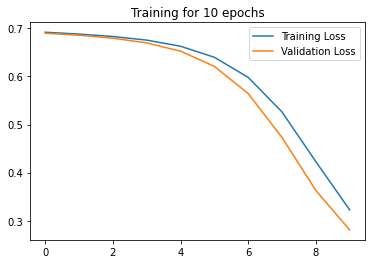

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training for ' +str(epochs)+ ' epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()



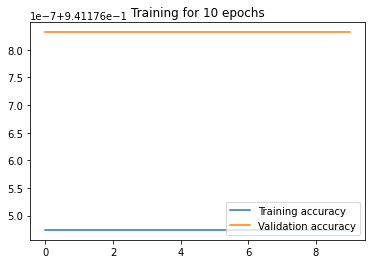

In [37]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Training for ' +str(epochs)+ ' epochs')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.show()

In [38]:
# Use Convolution Neural Networks using Transfer Learning technique to build a classifier 

from keras.applications import vgg16
from keras.models import Model
from keras import optimizers

input_shape = (224, 224, 3)
vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

#last layer from vgg to be used
output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    
input_shape = vgg_model.output_shape[1]

VGG_model = Sequential()
VGG_model.add(tf.keras.layers.InputLayer(input_shape=(input_shape,)))
VGG_model.add(tf.keras.layers.Dense(512, activation='relu', input_dim=input_shape))
VGG_model.add(tf.keras.layers.Dropout(0.3))
VGG_model.add(tf.keras.layers.Dense(256, activation='relu'))
VGG_model.add(tf.keras.layers.Dropout(0.3))
VGG_model.add(tf.keras.layers.Dense(128, activation='relu'))
VGG_model.add(tf.keras.layers.Dropout(0.3))
VGG_model.add(tf.keras.layers.Dense(17, activation='softmax'))

VGG_model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['accuracy'])
VGG_model.summary()




Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 17)               

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [39]:
#Train and Validation input wrt vgg model
X_vgg_train = vgg_model.predict(X_train)
X_vgg_val = vgg_model.predict(X_val)


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2401: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [40]:
history_vgg = VGG_model.fit(x=X_vgg_train, y=y_train,
                    validation_data=(X_vgg_val, y_val),
                    batch_size=30,
                    epochs=epochs,
                    verbose=1)

Train on 870 samples, validate on 218 samples
Epoch 1/10
870/870 [==============================] - ETA: 0s - loss: 0.4305 - acc: 0.9368

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


870/870 [==============================] - 4s 5ms/sample - loss: 0.4305 - acc: 0.9368 - val_loss: 0.2481 - val_acc: 0.9412
Epoch 2/10
870/870 [==============================] - 4s 4ms/sample - loss: 0.3339 - acc: 0.9324 - val_loss: 0.2376 - val_acc: 0.9412
Epoch 3/10
870/870 [==============================] - 4s 4ms/sample - loss: 0.3042 - acc: 0.9346 - val_loss: 0.2294 - val_acc: 0.9412
Epoch 4/10
870/870 [==============================] - 4s 4ms/sample - loss: 0.2912 - acc: 0.9359 - val_loss: 0.2300 - val_acc: 0.9412
Epoch 5/10
870/870 [==============================] - 4s 4ms/sample - loss: 0.2807 - acc: 0.9383 - val_loss: 0.2279 - val_acc: 0.9412
Epoch 6/10
870/870 [==============================] - 4s 4ms/sample - loss: 0.2764 - acc: 0.9388 - val_loss: 0.2297 - val_acc: 0.9412
Epoch 7/10
870/870 [==============================] - 4s 4ms/sample - loss: 0.2711 - acc: 0.9399 - val_loss: 0.2284 - val_acc: 0.9412
Epoch 8/10
870/870 [==============================] - 4s 4ms/sample - los

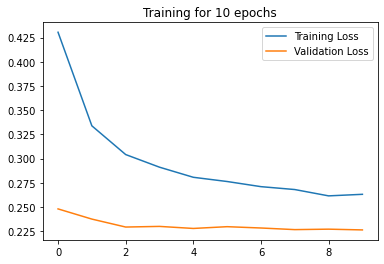

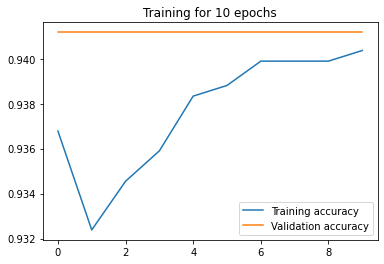

In [41]:
# Plots using TL
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title('Training for ' +str(epochs)+ ' epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

plt.plot(history_vgg.history['acc'])
plt.plot(history_vgg.history['val_acc'])
plt.title('Training for ' +str(epochs)+ ' epochs')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.show()

In [42]:
score = VGG_model.evaluate(X_vgg_train, y_train)
print('Training: ')
print('Train accuracy:', score[1])

score = VGG_model.evaluate(X_vgg_val, y_val)
print('validation ')
print('Test accuracy:', score[1])

Training: 
Train accuracy: 0.9411768
validation 
Test accuracy: 0.94117653


As training and testing accuracies are in same range, the Vgg model is best model in production

In [43]:
def getData_cl(index):
  getData(index)

Output()

Button(description='Predict', style=ButtonStyle())

zz  2


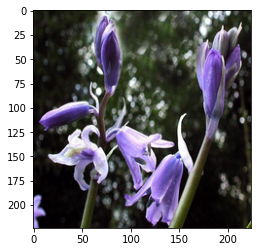

ValueError: ignored

In [44]:
import ipywidgets as widgets
from IPython.display import display
widgets.Label(value='CNN Image Classification Model GUI', disabled=True)

imageText = widgets.Text(
    value='',
    placeholder='Enter image index',
    description='FileName Index:',
    disabled=False
)



def callback(wdgt):
    # replace by something useful
    output.clear_output()
    display(wdgt.value)



output = widgets.Output()
display(output)

#imageText.on_submit(callback)
import_data_btn = widgets.Button(description='Import Data')
done_btn = widgets.Button(description='Done',style = {'button_color': 'yellow'})

input_widgets1 = widgets.HBox([imageText, import_data_btn, done_btn])
display(input_widgets1)

predict_btn = widgets.Button(description='Predict')
display(predict_btn)

def importdata_cb(b):
  output.clear_output()
  print ("zz ",imageText.value)
  with output:
        getData_cl(int(imageText.value))
  done_btn.style.button_color = 'green'


import_data_btn.on_click(importdata_cb)
 
def predict_cb(b):
  img = X_test[int(imageText.value)].reshape(1,224,224,3)
  y_pred=VGG_model.predict(img)
  print(y_pred)


predict_btn.on_click(predict_cb)

Explain in depth your strategy to maintain and support the AIML image classifier after it in production.

The model should get updated if there are changes or new additions of images or classes
The model should be robust and performnace orientied.
Model should be genearlised so that it can take care of future changes
In production, the model should able to run in automation without any assistance